<a href="https://colab.research.google.com/github/nachozobian/neural-network-pytorch-classification/blob/main/nn_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification with PyTorch

This notebook is a neural classification project using a toy dataset.

In [1]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 14)

In [2]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], 
                        "X2":X[:,1],
                        "label": y})

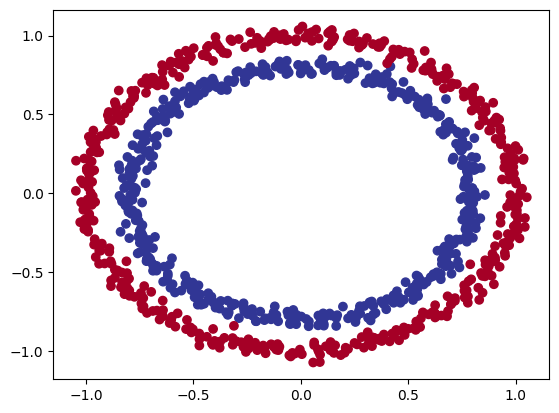

In [3]:
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y,
            cmap = plt.cm.RdYlBu);

When working on classification we're solving problems like this upper one! We'll practice the fundamentals with a dataset small enough
to practice the fundamentals. 

In the upper problem we're trying to decide whether the point belongs to the first or second ring.

### Turn data into tensors

In [4]:
import torch
torch.__version__

'2.0.0+cu118'

In [5]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

### Split data into train and test set

In [6]:
from sklearn.model_selection import train_test_split
#Using train_test_split is the easier way.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # 20% test
                                                    random_state = 14)

## Build a model

1. Setup device for training our model (we might to use a GPU)
2. Construct a model (by subclassing 'nn.Module')
3. Define a loss function and optimizer
4. Training and test loop

####1. Setup device for training our model. If there is a GPU available use a GPU 

In [7]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

####2. Construct a model.

In [8]:
class CircleModel0(nn.Module):
  def __init__(self):
    super().__init__()
    # Our model will have 2 Linear layers.
    self.layer_1 = nn.Linear(in_features=2, out_features=5) #In-features has to be 2
    self.layer_2 = nn.Linear(in_features=5, out_features=1) #Outputs a single feature
  
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

#Instanciate an instance of our model
model_0 = CircleModel0().to(device)
model_0

CircleModel0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
# Replicate the model above using nn.Sequential (easier)
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
#Make prediction with the initial random parameters of our untrained neural network
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \m{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels: \m{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: \mtensor([[1.],
        [0.],
        [-0.],
        [-0.],
        [1.],
        [-0.],
        [0.],
        [-0.],
        [1.],
        [-0.]])

First 10 labels: \mtensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 1.])


####3. Defining a loss function and optimizer.

For regression typically you want MAE or MSE but for a classification problem you'll be more likely to use binary cross entropy. A loss function measures how wrong your predictions are. This information is used by the algorithm to train itself! So it's important to know what loss function to use, this is problem specific and requires experience. 

For optimizers, SGD and Adam are the most common. Anyway PyTorch has many built-in options.

For the loss function we'll use `torch.nn.BECWithLogitsLoss()` which will help us using the binary cross entropy in a classification problem!

In [11]:
#Setup the loss funciton.
# loss_fn = nn.BCELoss() #requires inputs to have gone through the sigmoid activation prior to input BCELoss
loss_fn = nn.BCEWithLogitsLoss() #This loss fn combines the sigmoid with the BCE for us!! 

**NOTE:** According to PyTorch docs "this version of BCELoss is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability"

In [12]:
#We'll just use Stochastic Gradient Descent for this first example. Using Adam would be similar
optimizer = torch.optim.SGD(params= model_0.parameters(),
                           lr = 0.1) # Optimizes our NN parameters in order to lower our losses.

In [13]:
#Calculating accuracy -> (percentage)
def accuracy_fnc(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred)*100
  return acc

#### Train and test loop
To train our model we're going to need a training and testing loop

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

**What is a logit?** Logits are the raw outputs of our model. We can convert these logits into prediction probabilities by passing them to some kind of activation function - For binary classification we'll most likely be using a sigmoid function and for a multiclass classification we'll be using a softmax layer. 

Then, once we have our model's prediction probabilites, we'll need to **prediction labels** by either rounding them or whatever we find more suitable to do 


In [14]:
# View the first 5 outputs of the forward pass on the test data:
model_0.eval()
with torch.inference_mode():  
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.5083],
        [ 0.0784],
        [-0.0029],
        [-0.0174],
        [ 0.6337]])

In [15]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities.
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6244],
        [0.5196],
        [0.4993],
        [0.4957],
        [0.6533]])

In [16]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [0.],
        [0.],
        [1.]])

For our prediciton probability values we need some range-style rounding. 
* y_pred_probs >= 0.5 - y = 1 ***CLASS 1***
* y_pred_probs < 0.5 - y = 0  ***CLASS 0***

In [17]:
#Predicted labels
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 0., 0., 1.])

In [18]:
# Build training and test loop
torch.manual_seed(14)

#Cuda has also a manual seed if you're using a cuda device
#torch.cuda.manual_seed(14)


#Number of epochs set to 100
epochs = 100

#Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Build training and eval loop

for epoch in range(epochs):
  #Train
  model_0.train()
  #Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  #loss / accuracy
  loss = loss_fn(y_logits,
                 y_train)# Our BCEWithLogitsLoss (more stable than BCE) expects logits as inputs! 
  acc = accuracy_fnc(y_true= y_train, 
                     y_pred = y_pred)
  
  #Optimizer zero gradient
  optimizer.zero_grad()

  #Backpropagation
  loss.backward()

  #Optimizer step (SGD step)
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    #Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #Calculate loss and accuracy
    test_loss = loss_fn(test_logits, 
                        y_test)
    
    test_acc = accuracy_fnc(y_true=y_test,
                            y_pred = test_pred)
    
  if epoch%10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, acc {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.72157, acc 47.75% | Test Loss: 0.68333, Test acc 58.50%
Epoch: 10 | Loss: 0.71503, acc 48.12% | Test Loss: 0.68213, Test acc 58.50%
Epoch: 20 | Loss: 0.71052, acc 48.62% | Test Loss: 0.68183, Test acc 58.50%
Epoch: 30 | Loss: 0.70728, acc 48.50% | Test Loss: 0.68201, Test acc 58.00%
Epoch: 40 | Loss: 0.70487, acc 48.75% | Test Loss: 0.68242, Test acc 57.50%
Epoch: 50 | Loss: 0.70301, acc 48.62% | Test Loss: 0.68295, Test acc 56.50%
Epoch: 60 | Loss: 0.70156, acc 48.50% | Test Loss: 0.68353, Test acc 57.00%
Epoch: 70 | Loss: 0.70039, acc 48.62% | Test Loss: 0.68412, Test acc 57.00%
Epoch: 80 | Loss: 0.69944, acc 48.75% | Test Loss: 0.68471, Test acc 56.50%
Epoch: 90 | Loss: 0.69865, acc 48.88% | Test Loss: 0.68528, Test acc 56.00%


**Our dataset is `balanced` so an accuracy of 50% is really bad performance! Let's make the predictions visual:**

In [19]:
import requests
from pathlib import Path

#Helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exist")
else: 
  print("Donwloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Donwloading helper_functions.py


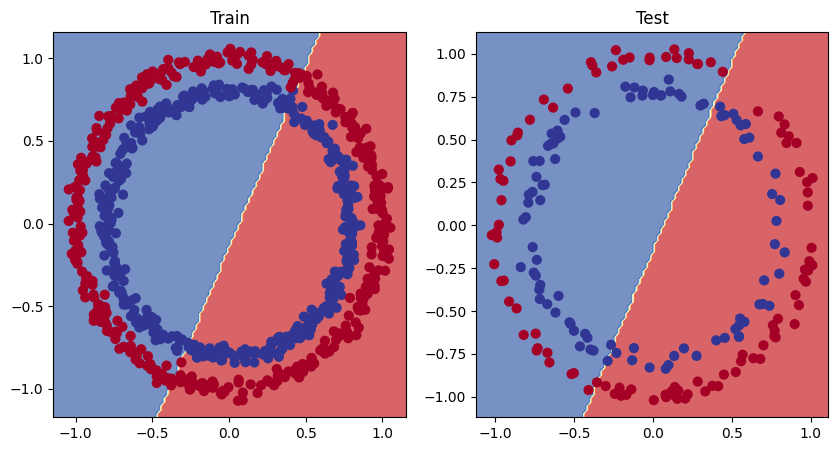

In [20]:
# Plot decision boundary of the model
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

The model is just dividing the space into a straight diagonal line. **That's why our accuracy is 50% approx!!** Why is our model doing that??? Does it has something to do with the fact that our NN only has Linear layers?

#### Improving our model

1. Adding more layers 
2. Add more hidden units
3. Add more epochs
4. Changing the activation functions
5. Learning rate badly chosen?

There is another options for improving a model and that's dealing with data perspective! For example adding more dots (more data) to our current dataset would definitely improve our results

In [21]:
class CircleModel1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x))) # Faster

model1 = CircleModel1().to(device)

In [22]:
#Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
#Create an optimizer
optim = torch.optim.SGD(params = model1.parameters(),
                         lr = 0.01)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  #Training
  model1.train()
  #Forward pass
  y_logits = model1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #Loss / Accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fnc(y_true = y_train, y_pred=y_pred)

  #Optimizer zero grad
  optim.zero_grad()

  #Loss backward
  loss.backward()

  # Optimizer step
  optim.step()

  ##Testing

  model1.eval()
  with torch.inference_mode():
    test_logits = model1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, 
                        y_test)
    test_acc = accuracy_fnc(y_true=y_test, y_pred = test_pred)

  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, acc {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69619, acc 50.50% | Test Loss: 0.70680, Test acc 48.00%
Epoch: 100 | Loss: 0.69343, acc 59.13% | Test Loss: 0.70286, Test acc 56.50%
Epoch: 200 | Loss: 0.69265, acc 53.62% | Test Loss: 0.70146, Test acc 46.50%
Epoch: 300 | Loss: 0.69243, acc 52.75% | Test Loss: 0.70093, Test acc 46.00%
Epoch: 400 | Loss: 0.69235, acc 52.62% | Test Loss: 0.70073, Test acc 45.50%
Epoch: 500 | Loss: 0.69233, acc 52.62% | Test Loss: 0.70066, Test acc 46.00%
Epoch: 600 | Loss: 0.69231, acc 51.62% | Test Loss: 0.70065, Test acc 46.00%
Epoch: 700 | Loss: 0.69231, acc 51.88% | Test Loss: 0.70067, Test acc 46.50%
Epoch: 800 | Loss: 0.69230, acc 52.12% | Test Loss: 0.70069, Test acc 46.50%
Epoch: 900 | Loss: 0.69229, acc 52.12% | Test Loss: 0.70072, Test acc 46.00%


Our model is still not useful. Our data is not linear! We cannot learn anything because our model is not suitable for this dataset.

#### Troubleshooting
Can the model we built learn anything at all? Since all our layers are linear - Could it fit a linear smaller problem?

In [26]:
#Creating some linear data

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias


#Train and test splits
train_split = int(0.8*len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

model2 = nn.Sequential(
    nn.Linear(in_features=1, out_features = 10),
    nn.Linear(in_features=10, out_features = 10),
    nn.Linear(in_features=10, out_features = 1),
).to(device) #Same model as before but changing the input/output number of features because we're applying it to a new smaller problem

model2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model2.parameters(), lr = 0.01) 


In [33]:
#Train de model
torch.manual_seed(14)


epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  y_pred = model2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Test
  model2.eval()
  with torch.inference_mode():
    test_pred = model2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.05300 Test Loss: 0.03124
Epoch: 100 | Loss: 0.00763 Test Loss: 0.00128
Epoch: 200 | Loss: 0.00642 Test Loss: 0.00156
Epoch: 300 | Loss: 0.00610 Test Loss: 0.00113
Epoch: 400 | Loss: 0.00639 Test Loss: 0.00139
Epoch: 500 | Loss: 0.00638 Test Loss: 0.00168
Epoch: 600 | Loss: 0.00636 Test Loss: 0.00122
Epoch: 700 | Loss: 0.00635 Test Loss: 0.00149
Epoch: 800 | Loss: 0.00603 Test Loss: 0.00106
Epoch: 900 | Loss: 0.00632 Test Loss: 0.00128


Loss seems to be going down so our model must be learning something. The problem with the circular dataset is that the model architecture does not 
suit the problem. **We need to add some non-linearity to deal with this non-linear dataset**

#### Non Linearities!


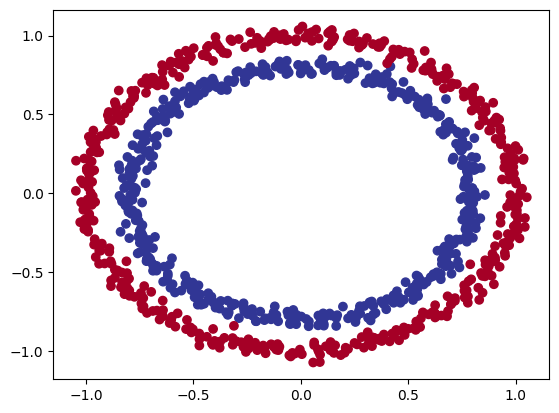

In [35]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state=14)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [36]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2, # 20% test
                                                    random_state = 14)

In [37]:
#Build a non linear model
from torch import nn

class CircleModel2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1 )
    self.relu = nn.ReLU() #Non-linear activation function

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model3 = CircleModel2().to(device)